In [1]:
import sys
sys.path.append('/home/xinyiz/pamrats')

In [2]:
##This is adapted from https://github.com/tkipf/gae/blob/master/gae/train.py and https://github.com/tkipf/pygcn/blob/master/pygcn/train.py##

import time
import os

# Train on CPU (hide GPU) due to memory constraints
# os.environ['CUDA_VISIBLE_DEVICES'] = ""

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim
from torch.utils.data import DataLoader
# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import average_precision_score

import image.loadImage as loadImage
import gae.gae.optimizer as optimizer
import gae.gae.model
import gae.gae.preprocessing as preprocessing
import image.modelsCNN as modelsCNN

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances

In [3]:
trainClusters=[0,1]
os.environ["CUDA_VISIBLE_DEVICES"] = "3" 
use_cuda=True

In [4]:
#load pretrained GAE
testepoch=9560

maskedgeName='knn20_connectivity'
hidden1=5000 #Number of units in hidden layer 1
hidden2=5000 #Number of units in hidden layer 2
# hidden3=2048
# hidden4=2048
# hidden5=128
fc_dim1=5000
# fc_dim2=128
# fc_dim3=128
# fc_dim4=128
# gcn_dim1=2600
# clf_hidden=256
adv_hidden=128

dropout=0.01
testNodes=0.1 #fraction of total nodes for testing
valNodes=0.05 #fraction of total nodes for validation
XreconWeight=20
# clfweight=20
advWeight=2
# randFeatureSubset=None
model_strGAE='gcn_vae_xa_e2_d1_dca'
protein=None #'scaled_binary'
proteinWeights=0.001
adj_decodeName=None #gala or None
ridgeL=0.01
shareGenePi=True

num_features=2112
training_samples=['disease13','control13']
training_sample_X='logminmax'
standardizeX=False
# name='allk20XA_01_dca_noD8' ###rename and retrain D8 C8
name='cd13k20XA_05_dca_over'
modelsavepath='/mnt/external_ssd/xinyi/models/train_gae_starmap/'+name
datadir='/home/xinyiz/2021-01-13-mAD-test-dataset'

#Load data
sampleidx={'disease13':'AD_mouse9494','control13':'AD_mouse9498','disease8':'AD_mouse9723','control8':'AD_mouse9735'}
savedir=os.path.join('/home/xinyiz/starmap')
adj_dir=os.path.join(savedir,'a')

featureslist={}
if training_sample_X in ['corrected','scaled']:
    scaleddata=scanpy.read_h5ad(datadir+'/2020-12-27-starmap-mAD-scaled.h5ad')
    
    for s in sampleidx.keys():
        featureslist[s+'X_'+'corrected']=torch.tensor(scaleddata.layers['corrected'][scaleddata.obs['sample']==sampleidx[s]])
        featureslist[s+'X_'+'scaled']=torch.tensor(scaleddata.layers['scaled'][scaleddata.obs['sample']==sampleidx[s]])

else:
    scaleddata=scanpy.read_h5ad(datadir+'/2020-12-27-starmap-mAD-raw.h5ad')
    
    for s in sampleidx.keys():
        scaleddata_train=scaleddata.X[scaleddata.obs['sample']==sampleidx[s]]

        if training_sample_X=='logminmax':
            featurelog_train=np.log2(scaleddata_train+1/2)
            scaler = MinMaxScaler()
            featurelog_train_minmax=np.transpose(scaler.fit_transform(np.transpose(featurelog_train)))
            featureslist[s+'X_'+training_sample_X]=torch.tensor(featurelog_train_minmax)
        elif training_sample_X=='logminmax10':
            featurelog_train=np.log2(scaleddata_train+1/2)
            scaler = MinMaxScaler(feature_range=(0,10))
            featurelog_train_minmax=np.transpose(scaler.fit_transform(np.transpose(featurelog_train)))
            featureslist[s+'X_'+training_sample_X]=torch.tensor(featurelog_train_minmax)

adj_list={}
adj_list['disease13']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9494.npz'))
adj_list['control13']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9498.npz'))
adj_list['disease8']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9723.npz'))
adj_list['control8']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9735.npz'))

adjnormlist={}
pos_weightlist={}
normlist={}
for ai in adj_list.keys():
    adjnormlist[ai]=preprocessing.preprocess_graph(adj_list[ai])
    
    pos_weightlist[ai] = torch.tensor(float(adj_list[ai].shape[0] * adj_list[ai].shape[0] - adj_list[ai].sum()) / adj_list[ai].sum()) #using full unmasked adj
    normlist[ai] = adj_list[ai].shape[0] * adj_list[ai].shape[0] / float((adj_list[ai].shape[0] * adj_list[ai].shape[0] - adj_list[ai].sum()) * 2)
    
    adj_label=adj_list[ai] + sp.eye(adj_list[ai].shape[0])
    adj_list[ai]=torch.tensor(adj_label.todense())
                
            
if 'dca' in model_strGAE:
    rawdata=scanpy.read_h5ad(datadir+'/2020-12-27-starmap-mAD-raw.h5ad')
    features_raw_list={}
    for s in sampleidx.keys():
#         features_raw_list[s+'X_'+'raw']=torch.tensor(rawdata.X[rawdata.obs['sample']==sampleidx[s]]).cuda()
        features_raw_list[s+'X_'+'raw']=torch.tensor(rawdata.X[rawdata.obs['sample']==sampleidx[s]])
    
if model_strGAE=='gcn_vae_xa_e2_d1_dca':
    modelgae = gae.gae.model.GCNModelVAE_XA_e2_d1_DCA(num_features, hidden1,hidden2,fc_dim1, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_zinb
    loss_a=optimizer.optimizer_CE
modelgae.load_state_dict(torch.load(os.path.join(modelsavepath,str(testepoch)+'.pt')))

if use_cuda:
    modelgae.cuda()

gaeLatent={}
modelgae.eval()
for s in sampleidx.keys():
    print(s)
    
    adj_norm=adjnormlist[s].cuda().float()
#     adj_label=adj_list[s].cuda().float()
    features=featureslist[s+'X_'+training_sample_X].cuda().float()
    
    if 'dca' in model_strGAE:
        features_raw=features_raw_list[s+'X_raw'].cuda()
    num_nodes,num_features = features.shape

    if adj_decodeName==None:
        _,_,_,z, _ = modelgae(features, adj_norm)
    else:
        adj_decode=adj_decode.cuda()
        adj_recon,mu,logvar,z, features_recon = modelgae(features, adj_norm,adj_decode)
    gaeLatent[s]=z.detach()

gaeClusterPath='/mnt/external_ssd/xinyi/plots/train_gae_starmap/allk20XA_02_dca_over/combinedlogminmax_beforeAct/cluster/leiden_nn10mdist025n_pcs40res0.1epoch9990'
with open(gaeClusterPath, 'rb') as input:
    gaeclusterlabels = pickle.load(input)
gaeclusterlabels=gaeclusterlabels.astype(int)
    
sampleNames=None
for s in sampleidx.keys():
    sampleidx_s=sampleidx[s] 
    if sampleNames is None:
        sampleNames=np.repeat(s,np.sum(scaleddata.obs['sample']==sampleidx_s))
    else:
        sampleNames=np.concatenate((sampleNames,np.repeat(s,np.sum(scaleddata.obs['sample']==sampleidx_s))),axis=None)

ncellstotal=0
cellCoord={}
for s in sampleidx.keys():
    print(s)
    sampleidx_s=sampleidx[s] 
    cidx=np.repeat(False,np.sum(scaleddata.obs['sample']==sampleidx_s))
    for c in trainClusters:
        cidx=np.logical_or(gaeclusterlabels[sampleNames==s]==c,cidx)
    cellCoord[s]=(((scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx_s,['y','x']].to_numpy())/0.3).astype(int))[cidx]
    gaeLatent[s]=gaeLatent[s][cidx]
    ncellstotal+=np.sum(cidx)
    
rawdata=None
scaleddata=None

disease13
control13
disease8
control8
disease13
control13
disease8
control8


In [5]:
# Settings
os.environ["CUDA_VISIBLE_DEVICES"] = "3" 
useSavedMaskedEdges=True
use_cuda=True
fastmode=False #Validate during training pass
seed=15
epochs=200
saveFreq=5
lr=0.00001 #initial learning rate
lr_adv=0.001
weight_decay=0 #Weight for L2 loss on embedding matrix.

batchsize=16
kernel_size=4
stride=2
padding=1

# fc_dim1=6000
hidden1=64 #Number of channels in hidden layer 1
hidden2=128 
hidden3=256
hidden4=256
hidden5=96
fc_dim1=96*25*25
fc_dim2=5000
# fc_dim3=128
# fc_dim4=128
# gcn_dim1=2600
# adv_hidden=128
fc_dim1_regrs=1024
fc_dim2_regrs=1024
fc_dim3_regrs=1024

dropout=0.01
testNodes=0.1 #fraction of total nodes for testing
valNodes=0.05 #fraction of total nodes for validation
# clfweight=20
advWeight=2
# randFeatureSubset=None
kl_weight=0.0000001
match_weight=1
model_str='cnn_vae'
model_str_regrs='fc_regrs3'
adv=None  #'clf_fc1_eq'  #'clf_fc1_control_eq' #'clf_fc1_control'  #'clf_fc1'

pretrainedAE=None #{'name':'controlphy5XAbin_01_dca','epoch':9990}
training_samples=['disease13','control13']
training_samples_regrs=['disease13','control13']
regrs_weight=0.001
# training_samples=['control13','control8']
targetBatch=None
diamThresh_mul=800
minThresh_mul=12
name='cd13_thresh25_02_cd13regrs_cluster01_mixedRotated'
plaqueMaskName='PlaqueMask6'
plaqueMaskImg='Maskofplaque6.tif'
lossThreshSize=1111
logsavepath='/mnt/external_ssd/xinyi/log/train_jointGAEcnn_starmap/'+name
modelsavepath='/mnt/external_ssd/xinyi/models/train_jointGAEcnn_starmap/'+name
plotsavepath='/mnt/external_ssd/xinyi/plots/train_jointGAEcnn_starmap/'+name

#Load data
sampleidx={'disease13':'AD_mouse9494','control13':'AD_mouse9498','disease8':'AD_mouse9723','control8':'AD_mouse9735'}
datadir='/home/xinyiz/2021-01-13-mAD-test-dataset'


        
# Set cuda and seed
np.random.seed(seed)
if use_cuda and (not torch.cuda.is_available()):
    print('cuda not available')
    use_cuda=False
torch.manual_seed(seed)
if use_cuda:
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.enabled = True

# Load data
# if randFeatureSubset != None:
#     idx=np.random.choice(features.shape[1],randFeatureSubset,replace=False)
#     features=features[:,idx]

In [6]:
if not os.path.exists(logsavepath):
    os.mkdir(logsavepath)
if not os.path.exists(modelsavepath):
    os.mkdir(modelsavepath)
if not os.path.exists(plotsavepath):
    os.mkdir(plotsavepath)

In [7]:
torch.manual_seed(seed)
if use_cuda:
    torch.cuda.manual_seed(seed)
loss_match=torch.nn.MSELoss(reduction='sum')
# Create model
if model_str=='cnn_vae':
    modelcnn = modelsCNN.CNN_VAE(kernel_size, stride, padding, 1, hidden1, hidden2, hidden3, hidden4, hidden5, fc_dim1,fc_dim2)
    loss_kl=optimizer.optimizer_kl
    loss_x=torch.nn.MSELoss(reduction='sum')

if model_str=='cnn_vae_alexnet':
    modelcnn = modelsCNN.CNN_VAE_alexnet(fc_dim1)
    loss_kl=optimizer.optimizer_kl
    loss_x=torch.nn.MSELoss(reduction='sum')

    
if adv=='clf_fc1' or adv=='clf_fc1_eq' or adv=='clf_fc1_control' or adv=='clf_fc1_control_eq':
    modelAdv=gae.gae.model.Clf_fc1(hidden2, dropout,adv_hidden,sampleLabellist_ae['control13'].size()[1])
    loss_adv=optimizer.optimizer_CEclf
    
if adv=='clf_linear1' or adv=='clf_linear1_control':
    modelAdv=gae.gae.model.Clf_linear1(hidden2, dropout,sampleLabellist_ae['control13'].size()[1])
    loss_adv=optimizer.optimizer_CEclf
        
if model_str_regrs=='fc_regrs3':
    modelRegrs = modelsCNN.FC_l3(fc_dim2,fc_dim1_regrs,fc_dim2_regrs,fc_dim3_regrs,1,0.5,regrs=True)
    lossCE=torch.nn.MSELoss(reduction='none')

In [8]:
features=None
features_raw=None
adj_norm=None
_=None
modelgae.cpu()
torch.cuda.empty_cache()


In [9]:
#train cnn only, matching gae
np.random.seed(seed)
torch.manual_seed(seed)
if use_cuda:
    torch.cuda.manual_seed(seed)
# model.load_state_dict(torch.load(os.path.join(modelsavepath,str(9360)+'.pt')))
# epochs=20000
# if pretrainedAE:
#     print('loading '+pretrainedAE['name']+' epoch '+str(pretrainedAE['epoch']))
#     model.load_state_dict(torch.load(os.path.join('/mnt/xinyi/pamrats/models/train_gae_starmap/'+pretrainedAE['name'],str(pretrainedAE['epoch'])+'.pt')))

if use_cuda:
    modelcnn.cuda()
    modelRegrs.cuda()
    if adv:
        modelAdv.cuda()
# modelcnn.load_state_dict(torch.load(os.path.join(modelsavepath,'51.pt')))

optimizerVAEXA = optim.Adam(modelcnn.parameters(), lr=lr, weight_decay=weight_decay)
if model_str_regrs:
    optimizerRegrs = optim.Adam(modelRegrs.parameters(), lr=lr, weight_decay=weight_decay)
if adv:
    optimizerAdv=optim.Adam(modelAdv.parameters(), lr=lr_adv, weight_decay=weight_decay)    


def train(epoch):
    t = time.time()
    modelcnn.train()
    modelRegrs.train()
    
    loss_kl_train_all=0
    loss_x_train_all=0
    loss_match_train_all=0
    loss_regrsMSE_all=0
    loss_regrsBinary_all=0
    loss_binary_all_pos=0
    loss_binary_all_neg=0
    loss_all=0
    ntrainBatches=int(np.ceil(train_nodes_idx.shape[0]/batchsize))
    for i in range(ntrainBatches):
        if i%200==0:
            print(i)
        trainIdx=train_nodes_idx[i*batchsize:min((i+1)*batchsize,train_nodes_idx.shape[0])]
        trainInput=torch.tensor(trainInputnp[trainIdx.numpy()])
        labels=torch.tensor(labelsnp[trainIdx.numpy()])
#         print(trainInput.shape)

        if use_cuda:
            trainInput=trainInput.cuda().float()
            labels=labels.cuda().float()
        optimizerVAEXA.zero_grad()
        optimizerRegrs.zero_grad()

        recon, z, mu, logvar = modelcnn(trainInput)
        pred = modelRegrs(z)
        
        #binary classification loss 
        if 'disease' in training_samples_t:
            loss_regrsBinary_all+=torch.sum(torch.logical_and(labels>0,pred.flatten()<lossThreshSize))*posweight
        loss_regrsBinary_all+=torch.sum(torch.logical_and(labels==0,pred.flatten()>=lossThreshSize))*negweight
        loss_binary_all_pos+=torch.sum(torch.logical_and(labels>0,pred.flatten()<lossThreshSize))
        loss_binary_all_neg+=torch.sum(torch.logical_and(labels==0,pred.flatten()>=lossThreshSize))

        weight_curr=torch.where(labels==0,torch.Tensor([negweight]).cuda(),torch.Tensor([posweight]).cuda())
        lossregrs=torch.mean(lossCE(pred.flatten(),labels)*weight_curr)
        loss_regrsMSE_all+=lossregrs.item()
        if i==0:
            print(pred.flatten()[:10])
            print(labels[:10])
        
        if adv and (training_samples_t in list(sampleLabellist_ae.keys())) and (training_samples_t != targetBatch):
            modelAdv.eval()
            advOut=modelAdv(z)

        loss_kl_train=loss_kl(mu, logvar,reduction='sum')
        loss_x_train=loss_x(recon, trainInput)
        loss_match_train=loss_match(z,gaetarget[trainIdx])
        loss=loss_kl_train*kl_weight+loss_x_train+loss_match_train*match_weight+lossregrs*regrs_weight
#         loss=loss_kl_train*kl_weight+loss_x_train+lossregrs*regrs_weight
        
        
        loss_kl_train_all+=loss_kl_train.item()
        loss_x_train_all+=loss_x_train.item()
        loss_match_train_all+=loss_match_train.item()
        loss_all+=loss.item()
        
        if adv and (training_samples_t in list(sampleLabellist_ae.keys())) and (training_samples_t != targetBatch):
            loss_adv_train=loss_adv(advOut,sampleLabel_ae,train_nodes_idx)
            loss+=loss_adv_train*advWeight
            
        loss.backward()
        optimizerVAEXA.step()
        if training_samples_t in training_samples_regrs:
            optimizerRegrs.step()

    loss_kl_train_all=loss_kl_train_all/train_nodes_idx.shape[0]
    loss_x_train_all=loss_x_train_all/train_nodes_idx.shape[0]
    loss_match_train_all=loss_match_train_all/train_nodes_idx.shape[0]
    loss_regrsMSE_all=loss_regrsMSE_all/train_nodes_idx.shape[0]
    loss_regrsBinary_all=loss_regrsBinary_all/train_nodes_idx.shape[0]/2
    loss_binary_all_pos=loss_binary_all_pos/np.sum(labelsnp[train_nodes_idx]>0)
    loss_binary_all_neg=loss_binary_all_neg/np.sum(labelsnp[train_nodes_idx]==0)
    loss_all=loss_all/train_nodes_idx.shape[0]
    
    trainInput=None
    torch.cuda.empty_cache()

    with torch.no_grad():
        modelcnn.eval()
        modelRegrs.eval()
        loss_x_val_all=0
        loss_match_val_all=0
        loss_regrsMSE_val_all=0
        loss_regrsBinary_val_all=0
        loss_val_binary_all_pos=0
        loss_val_binary_all_neg=0
        loss_val_all=0
        nvalBatches=int(np.ceil(val_nodes_idx.shape[0]/batchsize))
        for i in range(nvalBatches):
            valIdx=val_nodes_idx[i*batchsize:min((i+1)*batchsize,val_nodes_idx.shape[0])]
            valInput=torch.tensor(trainInputnp[valIdx.numpy()])
            labels=torch.tensor(labelsnp[valIdx.numpy()])
            if use_cuda:
                valInput=valInput.cuda().float()
                labels=labels.cuda().float()
            recon,z, mu, logvar = modelcnn(valInput)
            pred = modelRegrs(z)

            if adv and (training_samples_t in list(sampleLabellist_ae.keys())) and (training_samples_t != targetBatch):
                advOut=modelAdv(z)

            #binary classification loss 
            if 'disease' in training_samples_t:
                loss_regrsBinary_val_all+=torch.sum(torch.logical_and(labels>0,pred.flatten()<lossThreshSize))*posweight
            loss_regrsBinary_val_all+=torch.sum(torch.logical_and(labels==0,pred.flatten()>=lossThreshSize))*negweight
            loss_val_binary_all_pos+=torch.sum(torch.logical_and(labels>0,pred.flatten()<lossThreshSize))
            loss_val_binary_all_neg+=torch.sum(torch.logical_and(labels==0,pred.flatten()>=lossThreshSize))
        
            weight_curr=torch.where(labels==0,torch.Tensor([negweight]).cuda(),torch.Tensor([posweight]).cuda())
            lossregrs=torch.mean(lossCE(pred.flatten(),labels)*weight_curr)
            loss_regrsMSE_val_all+=lossregrs.item()
            if i==0:
                print(pred.flatten()[:10])
                print(labels[:10])

            loss_x_val=loss_x(recon, valInput).item()
            loss_match_val=loss_match(z,gaetarget[valIdx]).item()

            loss_x_val_all+=loss_x_val
            loss_match_val_all+=loss_match_val
            loss_val_all+=(loss_x_val+loss_match_val*match_weight+lossregrs*regrs_weight)
#             loss_val_all+=(loss_x_val+lossregrs*regrs_weight)

            if adv and (training_samples_t in list(sampleLabellist_ae.keys())) and (training_samples_t != targetBatch):
                loss_adv_val=loss_adv(advOut,sampleLabel_ae,val_nodes_idx)
                loss_val+=loss_adv_val*advWeight
        loss_x_val_all=loss_x_val_all/val_nodes_idx.shape[0]
        loss_match_val_all=loss_match_val_all/val_nodes_idx.shape[0]
        loss_regrsMSE_val_all=loss_regrsMSE_val_all/val_nodes_idx.shape[0]
        loss_regrsBinary_val_all=loss_regrsBinary_val_all/val_nodes_idx.shape[0]/2
        loss_val_binary_all_pos=loss_val_binary_all_pos/np.sum(labelsnp[val_nodes_idx]>0)
        loss_val_binary_all_neg=loss_val_binary_all_neg/np.sum(labelsnp[val_nodes_idx]==0)
        loss_val_all=loss_val_all/val_nodes_idx.shape[0]
    
    print(training_samples_t+' Epoch: {:04d}'.format(epoch),
          'loss_train: {:.4f}'.format(loss_all),
          'loss_kl_train: {:.4f}'.format(loss_kl_train_all),
          'loss_x_train: {:.4f}'.format(loss_x_train_all),
          'loss_match_train: {:.4f}'.format(loss_match_train_all),
          'loss_regrsMSE_train: {:.4f}'.format(loss_regrsMSE_all),
          'loss_regrsBinary_train: {:.4f}'.format(loss_regrsBinary_all),
          'loss_val: {:.4f}'.format(loss_val_all),
          'loss_x_val: {:.4f}'.format(loss_x_val_all),
          'loss_match_val: {:.4f}'.format(loss_match_val_all),
          'loss_regrsMSE_val: {:.4f}'.format(loss_regrsMSE_val_all),
          'loss_regrsBinary_val: {:.4f}'.format(loss_regrsBinary_val_all),
          'time: {:.4f}s'.format(time.time() - t))
    if adv and (training_samples_t in list(sampleLabellist_ae.keys())) and (training_samples_t != targetBatch):
        print('loss_adv_train: {:.4f}'.format(loss_adv_train.item()),
              'loss_adv_val: {:.4f}'.format(loss_adv_val.item())
             )
#     return loss.item(),loss_x_train.item(),loss_val.item(),loss_x_val.item()
#     return loss.item(),loss_kl_train.item(),loss_x_train.item(),loss_val.item(),loss_x_val.item()
    if adv:
        if (training_samples_t in list(sampleLabellist_ae.keys())) and (training_samples_t != targetBatch):
            return float(loss),float(loss_kl_train),float(loss_x_train),float(loss_a_train),float(loss_val),float(loss_x_val),float(loss_a_val),float(loss_adv_train),float(loss_adv_val)        
        else:
            return float(loss),float(loss_kl_train),float(loss_x_train),float(loss_a_train),float(loss_val),float(loss_x_val),float(loss_a_val),None,None   
    else:
        return loss_all,loss_kl_train_all,loss_x_train_all,loss_match_train_all,loss_regrsMSE_all,loss_regrsBinary_all,loss_val_all,loss_x_val_all,loss_match_val_all,loss_regrsMSE_val_all,loss_regrsBinary_val_all,loss_binary_all_pos,loss_binary_all_neg,loss_val_binary_all_pos,loss_val_binary_all_neg

def train_discriminator(epoch):
    t = time.time()
    model.eval()
    
    if adj_decodeName==None:
        adj_recon,mu,logvar,z,features_recon = model(features, adj_norm)
    #     features_recon, z, mu, logvar=model(features.float())
    else:
        adj_recon,mu,logvar,z,features_recon = model(features, adj_norm,adj_decode)
        
    
    if clf:
        modelClf.eval()
        clfOut=modelClf(z)
        
    modelAdv.train()
    optimizerAdv.zero_grad()
    advOut=modelAdv(z)
    
    loss_adv_train=loss_adv(advOut,sampleLabel_d,train_nodes_idx)
    loss = loss_adv_train*advWeight
    
    loss.backward()
    optimizerAdv.step()

    modelAdv.eval()
    advOut=modelAdv(z)
    loss_adv_val=loss_adv(advOut,sampleLabel_d,val_nodes_idx)
    loss_val=loss_adv_val*advWeight
    print(training_samples_t+' Epoch: {:04d}'.format(epoch),
          'loss_adv_train: {:.4f}'.format(loss_adv_train.item()),
          'loss_adv_val: {:.4f}'.format(loss_adv_val.item()),
          'time: {:.4f}s'.format(time.time() - t))
    return float(loss_adv_train),float(loss_adv_val)
    
# print('cross-validation ',seti)
train_loss_ep=[None]*epochs
train_loss_kl_ep=[None]*epochs
train_loss_x_ep=[None]*epochs
train_loss_match_ep=[None]*epochs
train_loss_regrsMSE_ep=[None]*epochs
train_loss_regrsBinary_ep=[None]*epochs
train_lossclfPos_ep=[None]*epochs
train_lossclfNeg_ep=[None]*epochs
# train_loss_adv_ep=[None]*epochs
# train_loss_advD_ep=[None]*epochs
val_loss_ep=[None]*epochs
val_loss_x_ep=[None]*epochs
val_loss_match_ep=[None]*epochs
val_loss_regrsMSE_ep=[None]*epochs
val_loss_regrsBinary_ep=[None]*epochs
val_lossclfPos_ep=[None]*epochs
val_lossclfNeg_ep=[None]*epochs
# val_loss_adv_ep=[None]*epochs
# val_loss_advD_ep=[None]*epochs
t_ep=time.time()

trainInputnp=np.zeros((ncellstotal,1,diamThresh_mul,diamThresh_mul))
labelsnp=np.zeros(ncellstotal)
gaetarget=torch.zeros((ncellstotal,fc_dim2))
currcells=0
for t in range(len(training_samples)):
    training_samples_t=training_samples[t]
    ncells_t=cellCoord[training_samples_t].shape[0]+currcells
    torch.cuda.empty_cache()
    training_samples_t=training_samples[t]
    if training_samples_t in training_samples_regrs:
        print('regression trained')
    if 'disease' in training_samples_t:
        plaqueMaskImg_s=plaqueMaskImg
    elif 'control' in training_samples_t:
        plaqueMaskImg_s=None
    trainInputnp[currcells:ncells_t],labelsnp[currcells:ncells_t]=loadImage.load_cellCentroid_plaque(plaqueMaskImg_s,cellCoord[training_samples_t],sampleidx[training_samples_t],datadir,diamThresh_mul,ifFlip='randomize',seed=3,imagename='pi_sum.tif',minmaxscale=True,nchannels=1)
    #         trainInputnp=loadImage.load_cellCentroid(cellCoord[training_samples_t],sampleidx[training_samples_t],datadir,diamThresh_mul,ifFlip=False,seed=3,imagename='pi_sum.tif',minmaxscale=True,nchannels=1)
    gaetarget[currcells:ncells_t]=gaeLatent[training_samples_t]
    currcells=ncells_t
gaetarget=gaetarget.cuda().float()

npos=0
nneg=0
npos=np.sum(labelsnp!=0)
nneg=labelsnp.shape[0]-npos
print(npos)
print(nneg)
negweight=(nneg+npos)/nneg
posweight=(nneg+npos)/npos



#         maskpath=os.path.join(savedir,'trainMask',training_samples_t+'_'+maskedgeName+'_seed'+str(seed)+'.pkl')
#         if useSavedMaskedEdges and os.path.exists(maskpath):
#     #         print('opening saved')
#             with open(maskpath, 'rb') as input:
#                 maskedgeres = pickle.load(input)
#         else:
    # construct training, validation, and test sets
maskedgeres= preprocessing.mask_nodes_edges(trainInputnp.shape[0],testNodeSize=testNodes,valNodeSize=valNodes,seed=seed)
#             with open(maskpath, 'wb') as output:
#                 pickle.dump(maskedgeres, output, pickle.HIGHEST_PROTOCOL)
train_nodes_idx,val_nodes_idx,test_nodes_idx = maskedgeres

for ep in range(epochs):
# for ep in range(10000,20000):

    
    if adv and (training_samples_t in list(sampleLabellist_ae.keys())):
#         sampleLabel_ae=sampleLabellist_ae[training_samples_t]
#         sampleLabel_d=sampleLabellist_d[training_samples_t]
        sampleLabel_ae=sampleLabellist_ae[training_samples_t].cuda().float()
        sampleLabel_d=sampleLabellist_d[training_samples_t].cuda().float()
    
    if adv:
        train_loss_ep[ep],train_loss_kl_ep[ep],train_loss_x_ep[ep],train_loss_a_ep[ep],val_loss_ep[ep],val_loss_x_ep[ep],val_loss_a_ep[ep],train_loss_adv_ep[ep],val_loss_adv_ep[ep]=train(ep)
        if (training_samples_t in list(sampleLabellist_ae.keys())):
            train_loss_advD_ep[ep],val_loss_advD_ep[ep]=train_discriminator(ep)
    else:
        train_loss_ep[ep],train_loss_kl_ep[ep],train_loss_x_ep[ep],train_loss_match_ep[ep],train_loss_regrsMSE_ep[ep],train_loss_regrsBinary_ep[ep],val_loss_ep[ep],val_loss_x_ep[ep],val_loss_match_ep[ep],val_loss_regrsMSE_ep[ep],val_loss_regrsBinary_ep[ep],train_lossclfPos_ep[ep],train_lossclfNeg_ep[ep],val_lossclfPos_ep[ep],val_lossclfNeg_ep[ep]=train(ep)

        
    if ep%saveFreq == 0:
        torch.save(modelcnn.state_dict(), os.path.join(modelsavepath,str(ep)+'.pt'))
        torch.save(modelRegrs.state_dict(),os.path.join(modelsavepath,str(ep)+'Regrs.pt'))
    if use_cuda:
#         modelcnn.cuda()
        torch.cuda.empty_cache()
print(' total time: {:.4f}s'.format(time.time() - t_ep))


regression trained
(22210, 22344)
regression trained
(22355, 18953)
1285
9210
0
tensor([0.0000, 0.0202, 0.0000, 0.0399, 0.0033, 0.1849, 0.1108, 0.0027, 0.0410,
        0.0916], device='cuda:0', grad_fn=<SliceBackward>)
tensor([    0.,     0.,     0.,  1751.,     0.,     0.,     0., 38353.,     0.,
            0.], device='cuda:0')
200
400
tensor([212.3585, 212.3585, 452.1621, 212.3585, 718.5786, 981.3838, 212.3585,
        586.2770, 687.8876, 531.6467], device='cuda:0')
tensor([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0., 12730.,
            0.], device='cuda:0')
control13 Epoch: 0000 loss_train: 158368.3948 loss_kl_train: 8024.7336 loss_x_train: 78248.9268 loss_match_train: 3639.4856 loss_regrsMSE_train: 76479978.5510 loss_regrsBinary_train: 0.0001 loss_val: 169978.1406 loss_x_val: 48976.6103 loss_match_val: 2052.6874 loss_regrsMSE_val: 118948851.3582 loss_regrsBinary_val: 0.0011 time: 356.2776s
0
tensor([ 189.6287,  733.8626,  200.6353, 1051.0945,  191.7621,  217.2

tensor([ 2872.5984, 15695.2256,  3094.0188, 14469.3467,  2962.2798,  3212.9902,
         3129.4302,  9701.1729, 20767.3340,  2701.2732], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([    0.,     0.,     0.,  1751.,     0.,     0.,     0., 38353.,     0.,
            0.], device='cuda:0')
200
400
tensor([ 4825.4424,  4825.4424,  9582.7002,  4825.4424,  8648.6787, 12981.0508,
         4825.4424,  4736.9995, 17892.9941,   348.5363], device='cuda:0')
tensor([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0., 12730.,
            0.], device='cuda:0')
control13 Epoch: 0009 loss_train: 10769367.2296 loss_kl_train: 7423992.7004 loss_x_train: 4481.0506 loss_match_train: 10669159.6944 loss_regrsMSE_train: 95725677.8677 loss_regrsBinary_train: 0.4287 loss_val: 93345.2500 loss_x_val: 6728.4292 loss_match_val: 2365.8884 loss_regrsMSE_val: 84250929.1048 loss_regrsBinary_val: 0.4558 time: 360.1323s
0
tensor([ 3554.1160, 39235.9609,  3209.2512, 17906.0840,  3099.8525,  3408.831

tensor([ 2431.6072,  1947.2170,  2608.1594,  6301.3335,  2617.5190,  2444.1699,
         2788.5820, 25480.9590,  9065.4375,  2478.8521], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([    0.,     0.,     0.,  1751.,     0.,     0.,     0., 38353.,     0.,
            0.], device='cuda:0')
200
400
tensor([3913.9114, 3913.9114, 6399.8887, 3913.9114,    0.0000, 3950.8474,
        3913.9114,    0.0000, 7735.6538,  151.9217], device='cuda:0')
tensor([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0., 12730.,
            0.], device='cuda:0')
control13 Epoch: 0018 loss_train: 153074.1815 loss_kl_train: 65459.3926 loss_x_train: 1796.3238 loss_match_train: 110235.0594 loss_regrsMSE_train: 41042789.7232 loss_regrsBinary_train: 0.4347 loss_val: 96086.8203 loss_x_val: 6043.2526 loss_match_val: 1582.2587 loss_regrsMSE_val: 88461302.2781 loss_regrsBinary_val: 0.4308 time: 356.5154s
0
tensor([2.2410e+03, 1.1250e+00, 2.2251e+03, 5.5193e+02, 2.0171e+03, 2.1308e+03,
        2.275

tensor([ 2203.2351,  4423.6172,  2001.8678, 18201.6621,  1999.4352,  1859.8695,
         2161.5068, 22540.6211, 16755.7500,  2136.7981], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([    0.,     0.,     0.,  1751.,     0.,     0.,     0., 38353.,     0.,
            0.], device='cuda:0')
200
400
tensor([ 3013.6072,  3013.6072, 13093.6777,  3013.6072,  6669.6626, 16857.4355,
         3013.6072,     0.0000, 17829.5762, 17582.1816], device='cuda:0')
tensor([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0., 12730.,
            0.], device='cuda:0')
control13 Epoch: 0027 loss_train: 930267.1269 loss_kl_train: 567138.2708 loss_x_train: 1060.4153 loss_match_train: 889295.4350 loss_regrsMSE_train: 39911223.4372 loss_regrsBinary_train: 0.3703 loss_val: 86926.3828 loss_x_val: 1261.1591 loss_match_val: 1526.4323 loss_regrsMSE_val: 84138781.3562 loss_regrsBinary_val: 0.4623 time: 356.0781s
0
tensor([ 1261.2698,  1045.9445,  1405.8400,  7005.5928,  1398.7805,  1352.0575,
  

0
tensor([  360.3486, 30802.3418,   309.5227,  7836.4546,   400.6247,   347.9037,
          387.2401, 34730.3164, 22771.5117,   429.4833], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([    0.,     0.,     0.,  1751.,     0.,     0.,     0., 38353.,     0.,
            0.], device='cuda:0')
200
400
tensor([3.3214e+03, 3.3214e+03, 2.4223e+01, 3.3214e+03, 2.9935e+03, 1.8108e+04,
        3.3214e+03, 1.5844e+01, 2.7259e+01, 2.2652e+04], device='cuda:0')
tensor([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0., 12730.,
            0.], device='cuda:0')
control13 Epoch: 0036 loss_train: 69712.1441 loss_kl_train: 72717.1153 loss_x_train: 1149.9638 loss_match_train: 32305.8148 loss_regrsMSE_train: 36256356.1418 loss_regrsBinary_train: 0.3595 loss_val: 99977.9062 loss_x_val: 6437.3809 loss_match_val: 1613.0935 loss_regrsMSE_val: 91927417.2876 loss_regrsBinary_val: 0.4417 time: 356.6681s
0
tensor([  431.5203, 21417.6328,   371.1970,  3725.3337,   276.1632,   409.9150,
   

tensor([5.1456e+01, 1.4178e+02, 1.3242e+02, 7.8378e+03, 3.0445e+01, 6.8722e+01,
        1.0721e+02, 2.1830e+04, 1.8900e+02, 4.3953e+00], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([    0.,     0.,     0.,  1751.,     0.,     0.,     0., 38353.,     0.,
            0.], device='cuda:0')
200
400
tensor([3.2391e+01, 3.2391e+01, 3.4310e+02, 3.2391e+01, 7.8530e+01, 5.7662e+04,
        3.2391e+01, 2.0906e+02, 1.2407e+02, 4.9335e+03], device='cuda:0')
tensor([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0., 12730.,
            0.], device='cuda:0')
control13 Epoch: 0045 loss_train: 116412.7110 loss_kl_train: 187617.9129 loss_x_train: 1197.3343 loss_match_train: 60313.7200 loss_regrsMSE_train: 54901635.6056 loss_regrsBinary_train: 0.0707 loss_val: 119234.9062 loss_x_val: 1450.1881 loss_match_val: 2759.7865 loss_regrsMSE_val: 115024946.8724 loss_regrsBinary_val: 0.0966 time: 356.4957s
0
tensor([   41.5307,  1882.8408,    68.3753, 10257.7344,    62.3259,    52.7134,
 

tensor([ 3553.8208,   497.9817,  3260.9641,   260.1612,  3166.5073,  3613.5515,
         3339.6113, 18724.9492,   492.3545,  3552.4912], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([    0.,     0.,     0.,  1751.,     0.,     0.,     0., 38353.,     0.,
            0.], device='cuda:0')
200
400
tensor([   63.5841,    63.5841,   395.2018,    63.5841,   124.0658, 40487.2539,
           63.5841,   716.1436,   215.9853,  3732.8850], device='cuda:0')
tensor([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0., 12730.,
            0.], device='cuda:0')
control13 Epoch: 0054 loss_train: 26794496932.8214 loss_kl_train: 9306245718.9115 loss_x_train: 1019.3011 loss_match_train: 26793731759.5335 loss_regrsMSE_train: 763769269.3955 loss_regrsBinary_train: 0.2361 loss_val: 115083.7500 loss_x_val: 1954.1333 loss_match_val: 2210.4715 loss_regrsMSE_val: 110919141.5810 loss_regrsBinary_val: 0.1259 time: 356.7357s
0
tensor([ 2728.1697,   432.0053,  2935.5669,  7846.2910,  2608.803

tensor([25349.3320, 17045.2891, 24175.0586, 16254.2295, 27356.1504, 24731.1758,
        25048.0879, 14804.0176,  7839.4849, 26127.2852], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([    0.,     0.,     0.,  1751.,     0.,     0.,     0., 38353.,     0.,
            0.], device='cuda:0')
200
400
tensor([47463.7305, 47463.7305,  9744.7275, 47463.7305,  9744.2139, 13558.0107,
        47463.7305, 11981.2148, 10569.2822, 10338.9014], device='cuda:0')
tensor([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0., 12730.,
            0.], device='cuda:0')
control13 Epoch: 0063 loss_train: 74567976228.3381 loss_kl_train: 26166275641.6353 loss_x_train: 4711.5837 loss_match_train: 73524108961.7654 loss_regrsMSE_train: 1043862825141.5354 loss_regrsBinary_train: 0.5007 loss_val: 655263.0625 loss_x_val: 6487.4585 loss_match_val: 473991.3095 loss_regrsMSE_val: 174784403.3829 loss_regrsBinary_val: 0.4970 time: 356.5660s
0
tensor([24509.5586, 25099.9648, 25497.5938, 16300.3359, 26

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0')
tensor([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0., 12730.,
            0.], device='cuda:0')
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution 

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
400
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convoluti

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
200
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convoluti

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0')
tensor([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0., 12730.,
            0.], device='cuda:0')
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution 

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
400
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convoluti

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
200
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convoluti

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0')
tensor([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0., 12730.,
            0.], device='cuda:0')
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
control13 Ep

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
200
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convoluti

convolution exploded
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0')
tensor([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0., 12730.,
            0.], device='cuda:0')
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
control13 Epoch: 0084 loss_train: nan loss_kl_train: nan loss_x_train: nan loss_match_train: nan loss_regrsMSE_train:

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
200
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convoluti

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
control13 Epoch: 0089 loss_train: nan loss_kl_train: nan loss_x_train: nan loss_match_train: nan loss_regrsMSE_train: nan loss_regrsBinary_train: 0.0000 loss_val: nan loss_x_val: nan loss_match_val: nan loss_regrsMSE_val: nan loss_regrsBinary_val: 0.0000 time: 348.5000s
0
convolution exploded
tensor([nan, nan, nan, nan, nan, n

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
200
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convoluti

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
control13 Epoch: 0094 loss_train: nan loss_kl_train: nan loss_x_train: nan loss_match_train: nan loss_regrsMSE_train: nan loss_regrsBinary_train: 0.0000 loss_val: nan loss_x_val: nan loss_match_val: nan loss_regrsMSE_val: nan loss_regrsBinary_val: 0.0000 time: 348.1171s
0
convolution exploded
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([    0.,     0.,     0.,

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
200
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convoluti

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
control13 Epoch: 0099 loss_train: nan loss_kl_train: nan loss_x_train: nan loss_match_train: nan loss_regrsMSE_train: nan loss_regrsBinary_train: 0.0000 loss_val: nan loss_x_val: nan loss_match_val: nan loss_regrsMSE_val: nan loss_regrsBinary_val: 0.0000 time: 348.2912s
0
convolution exploded
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([    0.,     0.,     0.,  1751.,     0.,     0.,     0., 38353.,     0.,
            0.], device='cuda:0')
convolution exploded
c

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
200
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convoluti

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
control13 Epoch: 0104 loss_train: nan loss_kl_train: nan loss_x_train: nan loss_match_train: nan loss_regrsMSE_train: nan loss_regrsBinary_train: 0.0000 loss_val: nan loss_x_val: nan loss_match_val: nan loss_regrsMSE_val: nan loss_regrsBinary_val: 0.0000 time: 348.1748s
0
convolution exploded
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([    0.,     0.,     0.,  1751.,     0.,     0.,     0., 38353.,     0.,
            0.], device='cuda:0')
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
c

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
200
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convoluti

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
control13 Epoch: 0109 loss_train: nan loss_kl_train: nan loss_x_train: nan loss_match_train: nan loss_regrsMSE_train: nan loss_regrsBinary_train: 0.0000 loss_val: nan loss_x_val: nan loss_match_val: nan loss_regrsMSE_val: nan loss_regrsBinary_val: 0.0000 time: 348.3961s
0
convolution exploded
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([    0.,     0.,     0.,  1751.,     0.,     0.,     0., 38353.,     0.,
            0.], device='cuda:0')
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
c

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
400
convolution exploded
convolution exploded
convoluti

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
tensor([nan, 

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
control13 Epoch: 0114 loss_train: nan loss_kl_train: nan loss_x_train: nan loss_match_train: nan loss_regrsMSE_train: nan loss_regrsBinary_train: 0.0000 loss_val: nan loss_x_val: nan loss_match_val: nan loss_regrsMSE_val: nan loss_regrsBinary_val: 0.0000 time: 348.2785s
0
convolution exploded
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([    0.,     0.,     0.,  1751.,     0.,     0.,     0., 38353.,     0.,
            0.], device='cuda:0')
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
c

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
400
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convoluti

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0')
tensor([    0.,     0.,     0.,     0.,   

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
control13 Epoch: 0119 loss_train: nan loss_kl_train: nan loss_x_train: nan loss_match_train: nan loss_regrsMSE_train: nan loss_regrsBinary_train: 0.0000 loss_val: nan loss_x_val: nan loss_match_val: nan loss_regrsMSE_val: nan loss_regrsBinary_val: 0.0000 time: 348.5368s
0
convolution exploded
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([    0.,     0.,     0.,  1751.,     0.,     0.,     0., 38353.,     0.,
            0.], device='cuda:0')
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
c

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
400
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convoluti

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0')
tensor([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0., 12730.,
            0.], device='cuda:0')
convolution exploded
convolution 

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([    0.,     0.,     0.,  1751.,     0.,     0.,     0., 38353.,     0.,
            0.], device='cuda:0')
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
c

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
400
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convoluti

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0')
tensor([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0., 12730.,
            0.], device='cuda:0')
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution 

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
400
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convoluti

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
200
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convoluti

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0')
tensor([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0., 12730.,
            0.], device='cuda:0')
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution 

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
400
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convoluti

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
200
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convoluti

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0')
tensor([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0., 12730.,
            0.], device='cuda:0')
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
control13 Ep

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
200
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convoluti

convolution exploded
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0')
tensor([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0., 12730.,
            0.], device='cuda:0')
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
control13 Epoch: 0141 loss_train: nan loss_kl_train: nan loss_x_train: nan loss_match_train: nan loss_regrsMSE_train:

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
200
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convoluti

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
control13 Epoch: 0146 loss_train: nan loss_kl_train: nan loss_x_train: nan loss_match_train: nan loss_regrsMSE_train: nan loss_regrsBinary_train: 0.0000 loss_val: nan loss_x_val: nan loss_match_val: nan loss_regrsMSE_val: nan loss_regrsBinary_val: 0.0000 time: 348.4220s
0
convolution exploded
tensor([nan, nan, nan, nan, nan, n

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution e

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
200
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convoluti

convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
convolution exploded
control13 Epoch: 0151 loss_train: nan loss_kl_train: nan loss_x_train: nan loss_match_train: nan loss_regrsMSE_train: nan loss_regrsBinary_train: 0.0000 loss_val: nan loss_x_val: nan loss_match_val: nan loss_regrsMSE_val: nan loss_regrsBinary_val: 0.0000 time: 348.9276s
0
convolution exploded
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([    0.,     0.,     0.,

KeyboardInterrupt: 

In [10]:
# with open(os.path.join(logsavepath,'train_loss'), 'rb') as input:
#     train_loss_ep[:52]=pickle.load(input)[:52]
# with open(os.path.join(logsavepath,'train_loss_kl'), 'rb') as input:
#     train_loss_kl_ep[:52]=pickle.load(input)[:52]
# with open(os.path.join(logsavepath,'train_loss_x'), 'rb') as input:
#     train_loss_x_ep[:52]=pickle.load(input)[:52]
# with open(os.path.join(logsavepath,'train_loss_match'), 'rb') as input:
#     train_loss_match_ep[:52]=pickle.load(input)[:52]
# with open(os.path.join(logsavepath,'train_loss_regrsMSE'), 'rb') as input:
#     train_loss_regrsMSE_ep[:52]=pickle.load(input)[:52]
# with open(os.path.join(logsavepath,'train_loss_regrsBinary'), 'rb') as input:
#     train_loss_regrsBinary_ep[:52]=pickle.load(input)[:52]
# with open(os.path.join(logsavepath,'val_loss'), 'rb') as input:
#     val_loss_ep[:52]=pickle.load(input)[:52]
# with open(os.path.join(logsavepath,'val_loss_x'), 'rb') as input:
#     val_loss_x_ep[:52]=pickle.load(input)[:52]
# with open(os.path.join(logsavepath,'val_loss_match'), 'rb') as input:
#     val_loss_match_ep[:52]=pickle.load(input)[:52]
# with open(os.path.join(logsavepath,'val_loss_regrsMSE'), 'rb') as input:
#     val_loss_regrsMSE_ep[:52]=pickle.load(input)[:52]
# with open(os.path.join(logsavepath,'val_loss_regrsBinary'), 'rb') as input:
#     val_loss_regrsBinary_ep[:52]=pickle.load(input)[:52]
# with open(os.path.join(logsavepath,'train_loss_adv'), 'rb') as input:
#     train_loss_adv_ep[:9360]=pickle.load(input)
# with open(os.path.join(logsavepath,'val_loss_adv'), 'rb') as input:
#     val_loss_adv_ep[:9360]=pickle.load(input)
# with open(os.path.join(logsavepath,'train_loss_advD'), 'rb') as input:
#     train_loss_advD_ep[:9360]=pickle.load(input)
# with open(os.path.join(logsavepath,'val_loss_advD'), 'rb') as input:
#     val_loss_advD_ep[:9360]=pickle.load(input)
    
with open(os.path.join(logsavepath,'train_loss'), 'wb') as output:
    pickle.dump(train_loss_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_kl'), 'wb') as output:
    pickle.dump(train_loss_kl_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_x'), 'wb') as output:
    pickle.dump(train_loss_x_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_match'), 'wb') as output:
    pickle.dump(train_loss_match_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_regrsMSE'), 'wb') as output:
    pickle.dump(train_loss_regrsMSE_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_regrsBinary'), 'wb') as output:
    pickle.dump(train_loss_regrsBinary_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss'), 'wb') as output:
    pickle.dump(val_loss_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss_x'), 'wb') as output:
    pickle.dump(val_loss_x_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss_match'), 'wb') as output:
    pickle.dump(val_loss_match_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss_regrsMSE'), 'wb') as output:
    pickle.dump(val_loss_regrsMSE_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss_regrsBinary'), 'wb') as output:
    pickle.dump(val_loss_regrsBinary_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_clfPos'), 'wb') as output:
    pickle.dump(train_lossclfPos_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss_x_clfPos'), 'wb') as output:
    pickle.dump(val_lossclfPos_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_clfNeg'), 'wb') as output:
    pickle.dump(train_lossclfNeg_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss_x_clfNeg'), 'wb') as output:
    pickle.dump(val_lossclfNeg_ep, output, pickle.HIGHEST_PROTOCOL)
if adv:
    with open(os.path.join(logsavepath,'train_loss_adv'), 'wb') as output:
        pickle.dump(train_loss_adv_ep, output, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(logsavepath,'val_loss_adv'), 'wb') as output:
        pickle.dump(val_loss_adv_ep, output, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(logsavepath,'train_loss_advD'), 'wb') as output:
        pickle.dump(train_loss_advD_ep, output, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(logsavepath,'val_loss_advD'), 'wb') as output:
        pickle.dump(val_loss_advD_ep, output, pickle.HIGHEST_PROTOCOL)
# with open(os.path.join(logsavepath,'ct_unique'), 'wb') as output:
#     pickle.dump(ct_unique, output, pickle.HIGHEST_PROTOCOL)


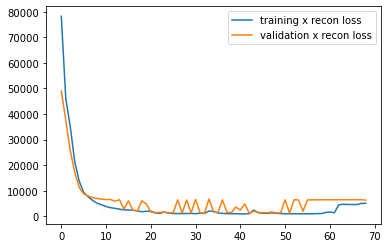

In [25]:
# plt.plot(np.arange(epochs),train_loss_ep)
# plt.plot(np.arange(epochs),val_loss_ep)
plt.plot(np.arange(epochs),train_loss_x_ep)
plt.plot(np.arange(epochs),val_loss_x_ep)
# plt.plot(np.arange(epochs),train_loss_match_ep)
# plt.plot(np.arange(epochs),val_loss_match_ep)
# plt.plot(np.arange(epochs),train_loss_regrsMSE_ep)
# plt.plot(np.arange(epochs),val_loss_regrsMSE_ep)
# plt.plot(np.arange(epochs),train_loss_regrsBinary_ep)
# plt.plot(np.arange(epochs),val_loss_regrsBinary_ep)
# plt.plot(np.arange(epochs),train_lossclfPos_ep)
# plt.plot(np.arange(epochs),val_lossclfPos_ep)
# plt.plot(np.arange(epochs),train_lossclfNeg_ep)
# plt.plot(np.arange(epochs),val_lossclfNeg_ep)
# plt.plot(np.arange(epochs),train_loss_kl_ep)
# plt.plot(np.arange(epochs),np.array(train_loss_adv_ep)*advWeight)
# plt.plot(np.arange(epochs),np.array(val_loss_adv_ep)*advWeight)
# plt.plot(np.arange(epochs),np.array(train_loss_advD_ep)*advWeight)
# plt.plot(np.arange(epochs),np.array(val_loss_advD_ep)*advWeight)
# plt.ylim((0,1e4))
# plt.xlim((0,60))
# plt.legend(['training loss','validation loss','training x recon loss','validation x recon loss','training kl loss'],loc='upper right')
# plt.legend(['training x recon loss','validation x recon loss','training a recon loss','validation a recon loss','training kl loss','training classifier loss','validation classifier loss'],loc='upper right')

# plt.legend(['training x recon loss','validation x recon loss','training match recon loss','validation match recon loss','training regrsMSE loss','validation regrsMSE loss','training regrsBinary loss','validation regrsBinary loss','training kl loss','training discriminator ae','validation discriminator ae','training discriminator d','validation discriminator d'],loc='upper right')
plt.legend(['training x recon loss','validation x recon loss','training match recon loss','validation match recon loss','training kl loss','training discriminator ae','validation discriminator ae','training discriminator d','validation discriminator d'],loc='upper right')
# plt.legend(['training match recon loss','validation match recon loss','training kl loss','training discriminator ae','validation discriminator ae','training discriminator d','validation discriminator d'],loc='upper right')
# plt.legend(['training regrsMSE loss','validation regrsMSE loss','training regrsBinary loss','validation regrsBinary loss','training kl loss','training discriminator ae','validation discriminator ae','training discriminator d','validation discriminator d'],loc='upper right')
# plt.legend(['train','val','train pos','val pos','train neg','val neg','validation discriminator d'],loc='upper right')
# plt.legend(['train pos','val pos','train neg','val neg','validation discriminator d'],loc='upper right')

# plt.legend(['training loss','validation loss','training x recon loss','validation x recon loss','training a recon loss','validation a recon loss','training kl loss','training discriminator ae','validation discriminator ae','training discriminator d','validation discriminator d'],loc='upper right')
plt.savefig(os.path.join(plotsavepath,'loss_seed3_x.jpg'))
plt.show()


In [63]:
np.arange(len(val_lossclfNeg_ep))[((np.array(val_lossclfNeg_ep)<0.45).astype(int)+(np.array(val_lossclfPos_ep)<0.45).astype(int))==2]
val_lossclfNeg_ep[30]

tensor(0.2308, device='cuda:0')

In [25]:
# name='c13k20XA_07_dca'
# logsavepath='/mnt/xinyi/pamrats/log/train_gae_starmap/'+name
# with open(os.path.join(logsavepath,'val_loss_a'), 'rb') as output:
#     val_loss_a_ep=pickle.load(output)
print(np.argsort(val_loss_regrsBinary_ep[:]))
print(np.sort(val_loss_regrsBinary_ep[:]))
# np.where(np.logical_not(np.isfinite(val_loss_ep[:])))
# print(val_loss_ep[35])

[  1  27  25  67  29  65 103 147 131  57 109  43  41 107 105  63 101  47
 111 117  97 143  51 145  99 149  85  19 155  69 187  23 115 195  49 193
  77 189 123  87 125  89  79  73  59 171  35  71  53 151  75 113  61  93
  95 127  31  45 165  37 133  33 137 119 139 141 177 121 175 191 197 185
 173 161 169 163 153 135 129  91  83 199  21  81  55  15 159  39 181 157
 183  13   3 167  17  11 179   5   9   7  10 124  34   8 182  16  36  18
  12  72 184 122 150  22  20   6  26 154 178  14 194 186 198 128 196 120
  70  30 134 174 152  68 130 106 172  82 180 112  52  42   4 126  96  94
  88  92 158 192 108 148 176 160 156  76  80  54  28 138  74 114 146  56
 116  32  24 104  50  78 140 100 190 110  38 188 118 136 168  98 142  40
   2 102   0 132  84 144  64  90  66 162  60  44  48  86 164 170  58  46
 166  62]
[tensor(0., device='cuda:0') tensor(0.0038, device='cuda:0')
 tensor(0.0038, device='cuda:0') tensor(0.0038, device='cuda:0')
 tensor(0.0038, device='cuda:0') tensor(0.0038, device='cuda:

In [14]:
np.argmin(val_loss_match_ep[:1340])

326

In [9]:
testepoch=72
modelcnn.load_state_dict(torch.load(os.path.join(modelsavepath,str(testepoch)+'.pt')))
modelRegrs.load_state_dict(torch.load(os.path.join(modelsavepath,str(testepoch)+'Regrs.pt')))
modelcnn.eval()
modelRegrs.eval()
if use_cuda:
    modelcnn.cuda()
    modelRegrs.cuda()
for s in sampleidx.keys():
    print(s)
    if 'disease' in s:
        plaqueMaskImg_s=plaqueMaskImg
    elif 'control' in s:
        plaqueMaskImg_s=None
    trainInputnp,labelsnp=loadImage.load_cellCentroid_plaque(plaqueMaskImg_s,cellCoord[s],sampleidx[s],datadir,diamThresh_mul,ifFlip=False,seed=3,imagename='pi_sum.tif',minmaxscale=True,nchannels=1)
#         trainInputnp=loadImage.load_cellCentroid(cellCoord[s],sampleidx[s],datadir,diamThresh_mul,ifFlip=False,seed=3,imagename='pi_sum.tif',minmaxscale=True,nchannels=1)

    gaetarget=gaeLatent[s]

#     maskpath=os.path.join(savedir,'trainMask',s+'_'+maskedgeName+'_seed'+str(seed)+'.pkl')
#     if useSavedMaskedEdges and os.path.exists(maskpath):
# #         print('opening saved')
#         with open(maskpath, 'rb') as input:
#             maskedgeres = pickle.load(input)
#     else:
#         # construct training, validation, and test sets
    maskedgeres= preprocessing.mask_nodes_edges(trainInputnp.shape[0],testNodeSize=testNodes,valNodeSize=valNodes,seed=seed)
    train_nodes_idx,val_nodes_idx,test_nodes_idx = maskedgeres

    if s not in training_samples:
        test_nodes_idx=torch.tensor(np.concatenate((train_nodes_idx,np.concatenate((val_nodes_idx,test_nodes_idx)))))
        
    loss_x_test_all=0
    loss_match_test_all=0
    loss_regrsBinary_pos_test_all=0
    loss_regrsBinary_neg_test_all=0
    npos=0
    nneg=0
    ntestBatches=int(np.ceil(test_nodes_idx.shape[0]/batchsize))
    for i in range(ntestBatches):
        testIdx=test_nodes_idx[i*batchsize:min((i+1)*batchsize,test_nodes_idx.shape[0])]
        testInput=torch.tensor(trainInputnp[testIdx.numpy()])
        labels=torch.tensor(labelsnp[testIdx.numpy()])
        if use_cuda:
            testInput=testInput.cuda().float()
            labels=labels.cuda().float()
        recon,z, mu, logvar = modelcnn(testInput)
        pred = modelRegrs(z)


        #binary classification loss 
        loss_regrsBinary_pos_test_all+=torch.sum(torch.logical_and(labels>0,pred.flatten()<lossThreshSize))
        loss_regrsBinary_neg_test_all+=torch.sum(torch.logical_and(labels==0,pred.flatten()>=lossThreshSize))
        npos+=torch.sum(labels>0)
#         print(npos)
        nneg+=torch.sum(labels==0)
        
        if i==0:
            print(pred.flatten()[:10])
            print(labels[:10])

        loss_x_test=loss_x(recon, testInput).item()
        loss_match_test=loss_match(z,gaetarget[testIdx]).item()

        loss_x_test_all+=loss_x_test
        loss_match_test_all+=loss_match_test

    loss_x_test_all=loss_x_test_all/test_nodes_idx.shape[0]
    loss_match_test_all=loss_match_test_all/test_nodes_idx.shape[0]
    loss_regrsBinary_pos_test_all=loss_regrsBinary_pos_test_all/npos
    loss_regrsBinary_neg_test_all=loss_regrsBinary_neg_test_all/nneg
    
        
    print('test results',
          'loss_x_test: {:.4f}'.format(loss_x_test_all),
         'loss_match_test: {:.4f}'.format(loss_match_test_all),
         'binaryPos_test: {:.4f}'.format(loss_regrsBinary_pos_test_all),
         'binaryNeg_test: {:.4f}'.format(loss_regrsBinary_neg_test_all))
#          'loss_adv_test: {:.4f}'.format(loss_adv_test.item()))

disease13
(22210, 22344)
tensor([    0.0000,     0.0000,     0.0000,  5693.2891, 47083.1797,   506.0174,
         5631.1763, 14558.2480], device='cuda:0', grad_fn=<SliceBackward>)
tensor([    0.,     0., 18786.,  3416., 35025., 21664., 44257.,     0.],
       device='cuda:0')
test results loss_x_test: 2203.1728 loss_match_test: 889.7797 binaryPos_test: 0.5538 binaryNeg_test: 0.4228
control13
(22355, 18953)
tensor([    0.0000, 25563.7637, 10361.5234,     0.0000,     0.0000, 20049.9492,
            0.0000,     0.0000], device='cuda:0', grad_fn=<SliceBackward>)
tensor([0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
test results loss_x_test: 2565.9843 loss_match_test: 1182.1259 binaryPos_test: nan binaryNeg_test: 0.2644
disease8
(22294, 19552)
tensor([    0.0000,     0.0000,     0.0000,     0.0000,     0.0000,   657.3454,
        27909.3047, 37811.3984], device='cuda:0', grad_fn=<SliceBackward>)
tensor([    0.,     0.,  6757., 11400.,     0., 20468.,  7616.,     0.],
       device='cuda

In [ ]:
print(sampleidx.keys())

In [25]:
trainInputnp=None

In [ ]:
features[:8,:8]

In [ ]:
zeroidx=(features_raw==0)
nonzeroidx=(features_raw!=0)
torch.sum(result[zeroidx])/torch.sum(result)

In [ ]:
torch.sum(result[zeroidx])

In [ ]:
# model.pi.weight[:8,:8]
model_str